In [47]:
from tensorflow.keras import layers
import pandas as pd
import numpy as np 
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import spacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras
from AttentionClass import Attention
from pathlib import Path
import csv, re, os 
from sklearn.preprocessing import StandardScaler
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle

In [40]:
def Load_Data(exeptions:list):
    # Get Input and Target Data
    input_data = np.ones([1, 60])
    target_data_binary_PHQ = [0]
    target_data_score_PHQ = [0]
    shape=[0]
    
    i = 1
    target_data_csv = Path('./full_dataset.csv')
    with open(target_data_csv, 'r') as csvFile:
        reader = csv.reader(csvFile)
        for row in reader:
            try:
                participant_ID = str(row[1])
                if row[2] in exeptions:
                  continue
                binary_PHQ8 = row[2]
                score_PHQ8 = row[2]
                
                csv_file_path = './Data/'   
                if os.path.exists(csv_file_path+participant_ID):
                    input_directory = Path(csv_file_path)
                    #print()
                    #for my_csv_filename in input_directory.glob(participant_ID):  
                        # Extract the .csv filename   
                    my_csv_filename = participant_ID 

                    io = pd.read_csv(csv_file_path+my_csv_filename, sep=",", usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60))

                    # Get the Matrix
                    i = i+1
                    io = np.array(io, dtype=np.float64)

                    shape=np.append(shape,io.shape[0])
                   
                    input_data = np.append(input_data, io, axis=0) 

                    for i in range(io.shape[0]):
                        target_data_binary_PHQ.append(binary_PHQ8)
                        target_data_score_PHQ.append(score_PHQ8)

            except ValueError:
                print("Skipping the following line: ", row[0])
    csvFile.close()            
                
    print("the size of my list-input-matrix: ", i)
    
    
    return input_data, target_data_binary_PHQ, target_data_score_PHQ, shape

# Loading data
input_data, target_data_binary_PHQ, target_data_score_PHQ ,shape_sequences= Load_Data(['A', 'E', 'L'])


the size of my list-input-matrix:  60


In [41]:
X = input_data[1:]
Y = target_data_binary_PHQ[1:]

In [42]:

Y = [[y] for y in Y]
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y)
Y = enc.transform(Y).toarray()

In [43]:
enc.categories_

[array(['F', 'N', 'T', 'W'], dtype=object)]

In [44]:
X_train,X_test, y_train, y_test = train_test_split(X,Y,test_size=0.20,random_state=102)

In [48]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Done Scaling!")
with open('scaler.pickle', 'wb') as handle:
    pickle.dump(scaler, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Dimensions Update
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("Done!")


Done Scaling!
Done!


(array([1.000e+00, 0.000e+00, 4.371e+03, 0.000e+00, 0.000e+00, 4.498e+03,
        0.000e+00, 8.127e+03, 0.000e+00, 6.156e+03]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

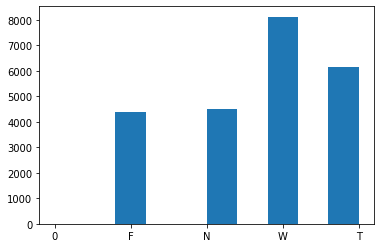

In [13]:
plt.hist(target_data_binary_PHQ)

In [14]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
 
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
class_weight = dict(enumerate(class_weights))

In [15]:
class_weight

{0: 1.3102009054895303,
 1: 1.28404048807543,
 2: 0.9397706515120763,
 3: 0.7174233033777503}

In [27]:
class_weight[0] = 4

In [28]:


def create_model():
  model = Sequential()
  model.add(layers.Bidirectional(layers.LSTM(units=100, return_sequences=True, dropout=0.25, recurrent_dropout=0.2),input_shape=(X_train.shape[1], 1)))
  model.add(layers.Bidirectional(layers.LSTM(units=60, return_sequences=True, dropout=0.25, recurrent_dropout=0.2)))
  model.add(Attention(60))
  model.add(layers.Dropout(rate=0.2))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(len(enc.categories_[0]), activation='softmax'))
  model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
  print(model.summary())
  return model

In [17]:
import os
try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

Found TPU at: grpc://10.20.148.202:8470


In [30]:
import tensorflow as tf
use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()

model.summary()

INFO:tensorflow:Initializing the TPU system: grpc://10.20.148.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.20.148.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 60, 200)           81600     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 60, 120)           125280    
_________________________________________________________________
attention_2 (Attention)      (None, 120)               180       
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               30976     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 239,064
Trainable params: 239,064
Non-trainable params: 0
________________________________________________

In [31]:

history = model.fit(X_train,y_train,epochs=150,verbose=1,validation_data=(X_test,y_test),
                    callbacks=[ModelCheckpoint(filepath='best_model.h5', monitor='val_accuracy', save_best_only=True,save_weights_only=True,class_weight=class_weight)])

Epoch 1/150
579/579 [==============================] - 41s 44ms/step - loss: 1.1136 - accuracy: 0.5032 - val_loss: 1.0373 - val_accuracy: 0.5398
Epoch 2/150
579/579 [==============================] - 22s 39ms/step - loss: 1.0238 - accuracy: 0.5431 - val_loss: 0.9806 - val_accuracy: 0.5649
Epoch 3/150
579/579 [==============================] - 22s 39ms/step - loss: 0.9638 - accuracy: 0.5649 - val_loss: 0.8788 - val_accuracy: 0.6124
Epoch 4/150
579/579 [==============================] - 23s 39ms/step - loss: 0.9155 - accuracy: 0.5867 - val_loss: 0.8455 - val_accuracy: 0.6282
Epoch 5/150
579/579 [==============================] - 23s 39ms/step - loss: 0.8876 - accuracy: 0.5985 - val_loss: 0.8150 - val_accuracy: 0.6418
Epoch 6/150
579/579 [==============================] - 23s 39ms/step - loss: 0.8687 - accuracy: 0.6089 - val_loss: 0.8418 - val_accuracy: 0.6325
Epoch 7/150
579/579 [==============================] - 23s 39ms/step - loss: 0.8371 - accuracy: 0.6208 - val_loss: 0.7873 - val_ac

In [20]:
best_model = create_model()
best_model.load_weights('best_model.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 60, 200)           81600     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 60, 120)           125280    
_________________________________________________________________
attention_1 (Attention)      (None, 120)               180       
_________________________________________________________________
dropout_1 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               30976     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 239,064
Trainable params: 239,064
Non-trainable params: 0
________________________________________________

In [32]:
predictions = model.predict(X_test)


In [39]:
print(predictions[:1])

[[1.05545205e-05 3.08008453e-06 9.99981880e-01 4.47836783e-06]]


In [33]:
enc.categories_

[array(['F', 'N', 'T', 'W'], dtype=object)]

In [34]:
Y_resuts = np.argmax(y_test, axis=1)
predictions_res = np.argmax(predictions, axis=1)


(array([ 837.,    0.,    0.,  892.,    0.,    0., 1229.,    0.,    0.,
        1673.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

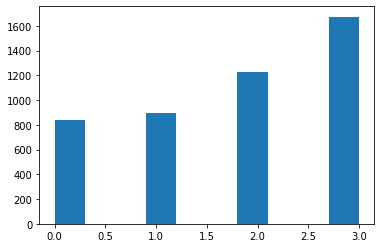

In [35]:
plt.hist(Y_resuts)

[[ 453   88   35  261]
 [  20  661  200   11]
 [   2   88 1137    2]
 [ 312   84   23 1254]]


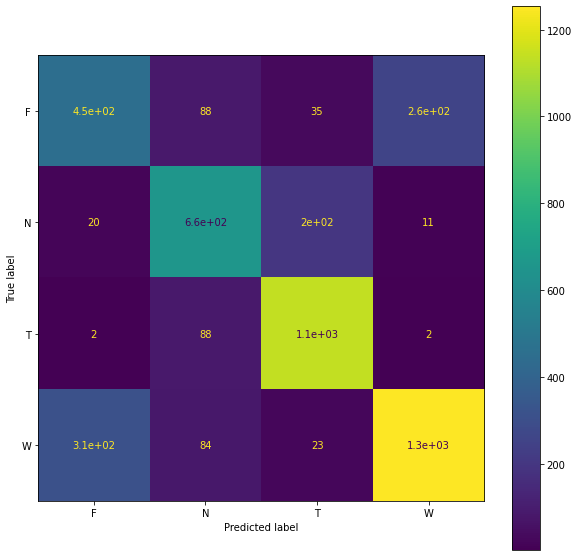

In [36]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score

labels = enc.categories_[0]

cm = confusion_matrix(Y_resuts, predictions_res)
print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

labels:
N = Neutral, T = sadness, W = anger, F = happiness

In [37]:
from sklearn.metrics import classification_report

print(classification_report(Y_resuts, predictions_res, target_names=labels))


              precision    recall  f1-score   support

           F       0.58      0.54      0.56       837
           N       0.72      0.74      0.73       892
           T       0.82      0.93      0.87      1229
           W       0.82      0.75      0.78      1673

    accuracy                           0.76      4631
   macro avg       0.73      0.74      0.73      4631
weighted avg       0.76      0.76      0.75      4631

